# Drilling MudLogs

### Import Libraries
We begin by importing the core Python libraries—pandas for tabular handling, matplotlib (with %matplotlib inline) and seaborn for plotting, plus warnings to mute extraneous messages.

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import warnings

#set seaborn style
sns.set_style("whitegrid")

# Turn off all warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Dataset

We then load the full mud-log CSV into a DataFrame df. Immediately looping through df.columns prints all 130+ parameter names, giving us a panoramic view of the available signals: everything from hole depth and ROP to gas returns, tank volumes, MWD vibration, motor torque, toolface, and more. This upfront inventory ensures we know exactly which measurements we can tap for our mud-logging analysis.

In [2]:
# df = pd.read_csv(r'C:\Users\hp\Datasets\Utah Forge Datasets\Drilling Data for Well 16A(78)-32.csv')

In [3]:
# Load your dataset with timestamp as the index
df = pd.read_csv(r'C:\Users\hp\Coding World\PE-Drilling Data Analytics\Datasets\MIP-5H Bottom.csv');


### Inspect Dataset

In [4]:
for i in df.columns:
    print(i)

Hole Depth
Rate Of Penetration
Bit Depth
Tank 3 Capacity
Time Of Penetration
Hook Load
Standpipe Pressure
Pump 1 strokes/min
Pump 2 strokes/min
Rotary RPM
Rotary Torque
Weight on Bit
On Bottom ROP
Flow
Total Mud Volume
Trip Tank Mud Volume
Line Wear
Tank 4 Capacity
Tank 1 Capacity
Pump 1 total strokes
Pump 2 total strokes
Tank 5 Capacity
Total Pump Output
TotalPumpDisplacement
Block Height
Mud Tank 1 Volume
Mud Tank 2 Volume
Mud Tank 3 Volume
Mud Tank 4 Volume
Mud Tank 5 Volume
Mud Tank 6 Volume
Mud Tank 7 Volume
Mud Tank 8 Volume
Pump 3 total strokes
On Bottom Hours
Circulating Hours
Tank 8 Capacity
Tool Face
Inclination
Azimuth
Downhole Pressure 1
Tank 2 Capacity
Mud G/L Alarm State
Magnetic Toolface
Gravity Toolface
MWD Vibration XYZ
MWD Temperature
Total Gas Return
MWD General Variable 1
MWD General Variable 2
MWD General Variable 3
MWD General Variable 4
MWD Vibration XY Gamma
MWD Vibration Z Gamma
Over Pull
Fill Strokes
Total Fill Strokes
Min Pressure
Min Hook Load
Min Torque
Min

### Selecting Key Mud-Log Variables
Raw mud-log tables often contain dozens of redundant or rarely used columns. Here we carve out a focused subset `dfa` containing the drill-centered metrics critical to real-time drilling diagnostics: timestamp (`YYYY/MM/DD` + `HH:MM:SS`), hole depth & diameter, rotary speed & torque, weight on bit, on-bottom ROP, flow rate, standpipe & differential pressures, total volume, gas readings (CO₂, H₂S, methane, butane, third-party), pump outputs & displacements, downhole temperature and return gas conditions. By trimming to these 25 columns, we streamline subsequent plotting logic while preserving the key indicators of bit performance, hydraulics and gas influx.

In [5]:
dfa = df[['YYYY/MM/DD',
          'Hole Depth',
          'HH:MM:SS',
          'Hole Diameter',
          'Rotary RPM',
          'Rotary Torque',
          'Weight on Bit', 
          'On Bottom ROP',
          'Flow',
          'Standpipe Pressure',
          'Differential Pressure',
          'Total Mud Volume',
          'CO2 Carbon Dioxide Gas',
          'Heavy Gas',
          'C1 Methane Gas',
          'C4 Butane Gas',
          'Total Pump Output',
          'TotalPumpDisplacement',
          'MWD Temperature',
          'Total Gas Return',
          'tgs Box Temperature',
          'tgs Block Temperature',
          'Pason Gas Unlagged',
          '3rd Party Gas',
          'Pason Gas']
         ]

### Single-Track ROP Log
To validate our slice and axis orientation, we extract rows 1000–3000—a representative ~2,000-row interval—then produce a single-panel plot of on-bottom ROP vs. hole depth. We invert the y-axis so depth increases downward, label the top x-axis for immediate glanceability, and add gridlines. This rapid sanity-check confirms that our subset indices align and that our axes conventions match industry expectations for mud-log displays.

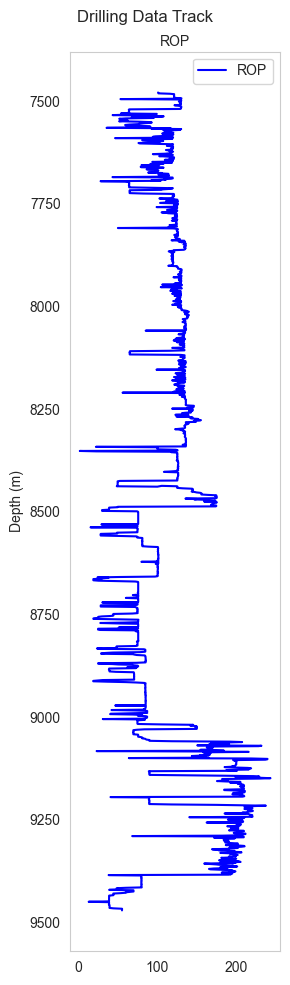

In [ ]:
data = dfa[1000:3000]
# Creating the figure and the subplot
fig, ax = plt.subplots(figsize=(3, 10))
fig.suptitle("Drilling Data Track")

# Plotting the ROP and curves on the same track
ax.plot(data["On Bottom ROP"], data["Hole Depth"], color="blue", label="ROP")
# ax.plot(data["Weight on Bit"], data["Hole Depth"], color="red", label="WOB")
ax.set_xlabel("ROP")
ax.set_ylabel("Depth (m)")
# top, bottom = data['On Bottom ROP'].min(), data['On Bottom ROP'].max()
# ax.set_xlim(top, bottom)
ax.legend(loc="upper right")
ax.grid()
ax.xaxis.set_label_position('top')

# Inverting the y-axis and adjusting the layout
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()


### Confirming Subset Columns
A quick `dfa.columns` print revisits our trimmed schema and reassures us that all selected parameters are present. This guardrail prevents typographical errors later when referencing columns by name in our multi-track function.

In [7]:
dfa.columns

Index(['YYYY/MM/DD', 'Hole Depth', 'HH:MM:SS', 'Hole Diameter', 'Rotary RPM',
       'Rotary Torque', 'Weight on Bit', 'On Bottom ROP', 'Flow',
       'Standpipe Pressure', 'Differential Pressure', 'Total Mud Volume',
       'CO2 Carbon Dioxide Gas', 'Heavy Gas', 'C1 Methane Gas',
       'C4 Butane Gas', 'Total Pump Output', 'TotalPumpDisplacement',
       'MWD Temperature', 'Total Gas Return', 'tgs Box Temperature',
       'tgs Block Temperature', 'Pason Gas Unlagged', '3rd Party Gas',
       'Pason Gas'],
      dtype='object')

### Defining the Multi-Track Mud-Log Function `(plot_mudlog`)
We encapsulate the full mud-log visualization into `plot_mudlog(data)`, which renders five side-by-side tracks sharing a common depth axis:

Track 1: Hole diameter (blue) and on-bottom ROP (red) plotted on dual x-axes, highlighting bit-geomorphology vs. penetration rate.

Track 2: Weight on bit (green) alongside rotary torque (purple), illuminating mechanical loading and torque‐induced drag.

Track 3: In-vs-out mud temperatures (orange/brown), diagnosing downhole cooling efficiency and potential blockages.

Track 4: Surface flowrate (cyan) vs. differential pressure (magenta), key for detecting loss/gain events or pack-off risk.

Track 5: H₂S (black) vs. CO₂ (blue) concentrations, essential for gas‐influx monitoring and safety planning.

Each subplot uses outward‐offset top axes for dual curves, shared inverted y-axis, and gridlines for precise cross-plot correlation.

In [ ]:
def plot_mudlog(data):
    # Creating the figure and the subplots
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 20), sharey=True)
    # fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10)
    fig.suptitle("Drilling Mud Log", fontsize=20, y=1.0, x=0.45)

    # plt.subplots_adjust(top=0.2, bottom=0.1)

    # Plotting the first track with Hole Diameter and ROP
    top1a, bottom1a = data['Hole Diameter'].min(), data['Hole Diameter'].max()
    ax1a = axes[0].twiny()
    ax1a.plot(data['Hole Diameter'], data["Hole Depth"], color="blue", label='Hole Diameter')
    ax1a.set_xlabel('Hole Diameter', color="blue")
    ax1a.set_xlim(top1a, bottom1a)
    ax1a.xaxis.set_ticks([top1a, bottom1a])
    ax1a.xaxis.set_label_position('top')
    ax1a.spines['top'].set_position(('outward', 0))

    top1b, bottom1b = data['On Bottom ROP'].min(), data['On Bottom ROP'].max()
    ax1b = axes[0].twiny()
    ax1b.plot(data["On Bottom ROP"], data["Hole Depth"], color="red", label="On Bottom ROP")
    ax1b.set_xlabel("On Bottom ROP", color="red")
    ax1b.set_xlim(bottom1b, top1b)
    # ax1b.xaxis.set_ticks([top1b, bottom1b])
    ax1b.xaxis.set_label_position('top')
    ax1b.spines['top'].set_position(('outward', 40))

    axes[0].set_ylabel("Depth (ft)")
    axes[0].grid()

    # Plotting the second track with lithology or gamma log
    top2a, bottom2a = data['Weight on Bit'].min(), data['Weight on Bit'].max()
    ax2a = axes[1].twiny()
    ax2a.plot(data["Weight on Bit"], data["Hole Depth"], color="green", label="Weight on Bit")
    ax2a.set_xlabel("Weight on Bit", color="green")
    ax2a.set_xlim(top2a, bottom2a)
    # ax2a.xaxis.set_ticks([3.2, 8.2, 13.2, 18.2, 23.2])
    ax2a.xaxis.set_label_position('top')
    ax2a.spines['top'].set_position(('outward', 0))

    top2b, bottom2b = data['Rotary Torque'].min(), data['Rotary Torque'].max()
    ax2b = axes[1].twiny()
    ax2b.plot(data["Rotary Torque"], data["Hole Depth"], color="purple", label="Rotary Torque")
    ax2b.set_xlabel("Rotary Torque", color="purple")
    ax2b.set_xlim(bottom2b, top2b)
    ax2b.xaxis.set_ticks([top2b, bottom2b])
    ax2b.xaxis.set_label_position('top')
    ax2b.spines['top'].set_position(('outward', 40)) 

    axes[1].grid()

    # Plotting the third track with temperature in and temperature out
    top3a, bottom3a = data['tgs Box Temperature'].min(), data['tgs Box Temperature'].max()
    ax3a = axes[2].twiny()
    ax3a.plot(data["tgs Box Temperature"], data["Hole Depth"], color="orange", label="Temperature In")
    ax3a.set_xlabel("Temperature In (°C)", color="orange")
    ax3a.set_xlim(top3a, bottom3a)
    ax3a.xaxis.set_ticks([top3a, bottom3a])
    ax3a.xaxis.set_label_position('top')
    ax3a.spines['top'].set_position(('outward', 0))

    top3b, bottom3b = data['tgs Block Temperature'].min(), data['tgs Block Temperature'].max()
    ax3b = axes[2].twiny()
    ax3b.plot(data["tgs Block Temperature"], data["Hole Depth"], color="brown", label="Temperature Out")
    ax3b.set_xlabel("Temperature Out (°C)", color="brown")
    ax3b.set_xlim(bottom3b, top3b)
    ax3b.xaxis.set_ticks([top3b, bottom3b])
    ax3b.xaxis.set_label_position('top')
    ax3b.spines['top'].set_position(('outward', 40))

    axes[2].grid() # Adding grid lines

    # Plotting the fourth track with pit total and pump pressure
    top4a, bottom4a = data['Flow'].min(), data['Flow'].max()
    ax4a = axes[3].twiny()
    ax4a.plot(data["Flow"], data["Hole Depth"], color="cyan", label="Flow")
    ax4a.set_xlabel("Flow", color="cyan")
    ax4a.set_xlim(top4a, bottom4a) 
    ax4a.xaxis.set_ticks([top4a, bottom4a])
    ax4a.xaxis.set_label_position('top') 
    ax4a.spines['top'].set_position(('outward', 0)) 

    top4b, bottom4b = data['Differential Pressure'].min(), data['Differential Pressure'].max()
    ax4b = axes[3].twiny() 
    ax4b.plot(data["Differential Pressure"], data["Hole Depth"], color="magenta", label="Differential Pressure")
    ax4b.set_xlabel("Differential Pressure", color="magenta")
    ax4b.set_xlim(bottom4b, top4b) 
    ax4b.xaxis.set_ticks([top4b, bottom4b])
    ax4b.xaxis.set_label_position('top')
    ax4b.spines['top'].set_position(('outward', 40))

    axes[3].grid()

    # Plotting the fifth track with H2S and CO2
    top5a, bottom5a = data['Pason Gas'].min(), data['Pason Gas'].max()
    ax5a = axes[4].twiny()
    ax5a.plot(data["Pason Gas"], data["Hole Depth"], color="black", label="H2S")
    ax5a.set_xlabel("H2S", color="black")
    ax5a.set_xlim(top5a, bottom5a)
    ax5a.xaxis.set_ticks([top5a, bottom5a])
    ax5a.xaxis.set_label_position('top')
    ax5a.spines['top'].set_position(('outward', 0))

    top5b, bottom5b = data['Pason Gas Unlagged'].min(), data['Pason Gas Unlagged'].max()
    ax5b = axes[4].twiny()
    ax5b.plot(data["Pason Gas Unlagged"], data["Hole Depth"], color="blue", label="CO2 (ppm)")
    ax5b.set_xlabel("CO2 (ppm)", color="blue")
    ax5b.set_xlim(bottom5b, top5b)
    ax5b.xaxis.set_ticks([top5b, bottom5b])
    ax5b.xaxis.set_label_position('top')
    ax5b.spines['top'].set_position(('outward', 40))

    axes[4].grid()

    # Leaving the sixth track empty for descriptions
    # axes[5].axis("off")
    # plt.subplots_adjust(top=3.85)

    # Inverting the y-axis and adjusting the layout
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    #plt.savefig('pic1.png')

### Cleaning Missing Flags and Final Plot
Before drawing our comprehensive mud-log, we replace the sentinel value `–999.25` (sensor-flagged “no data”) with zero to avoid visual gaps. Finally, calling `plot_mudlog(dfa[2000:2500]) `produces a detailed 500-row window of our five-track mud-log—an interactive-style snapshot that drilling engineers can use to inspect bit, hydraulic and gas behavior across a targeted depth interval.

In [14]:
dfa = dfa.replace(-999.25, 0)

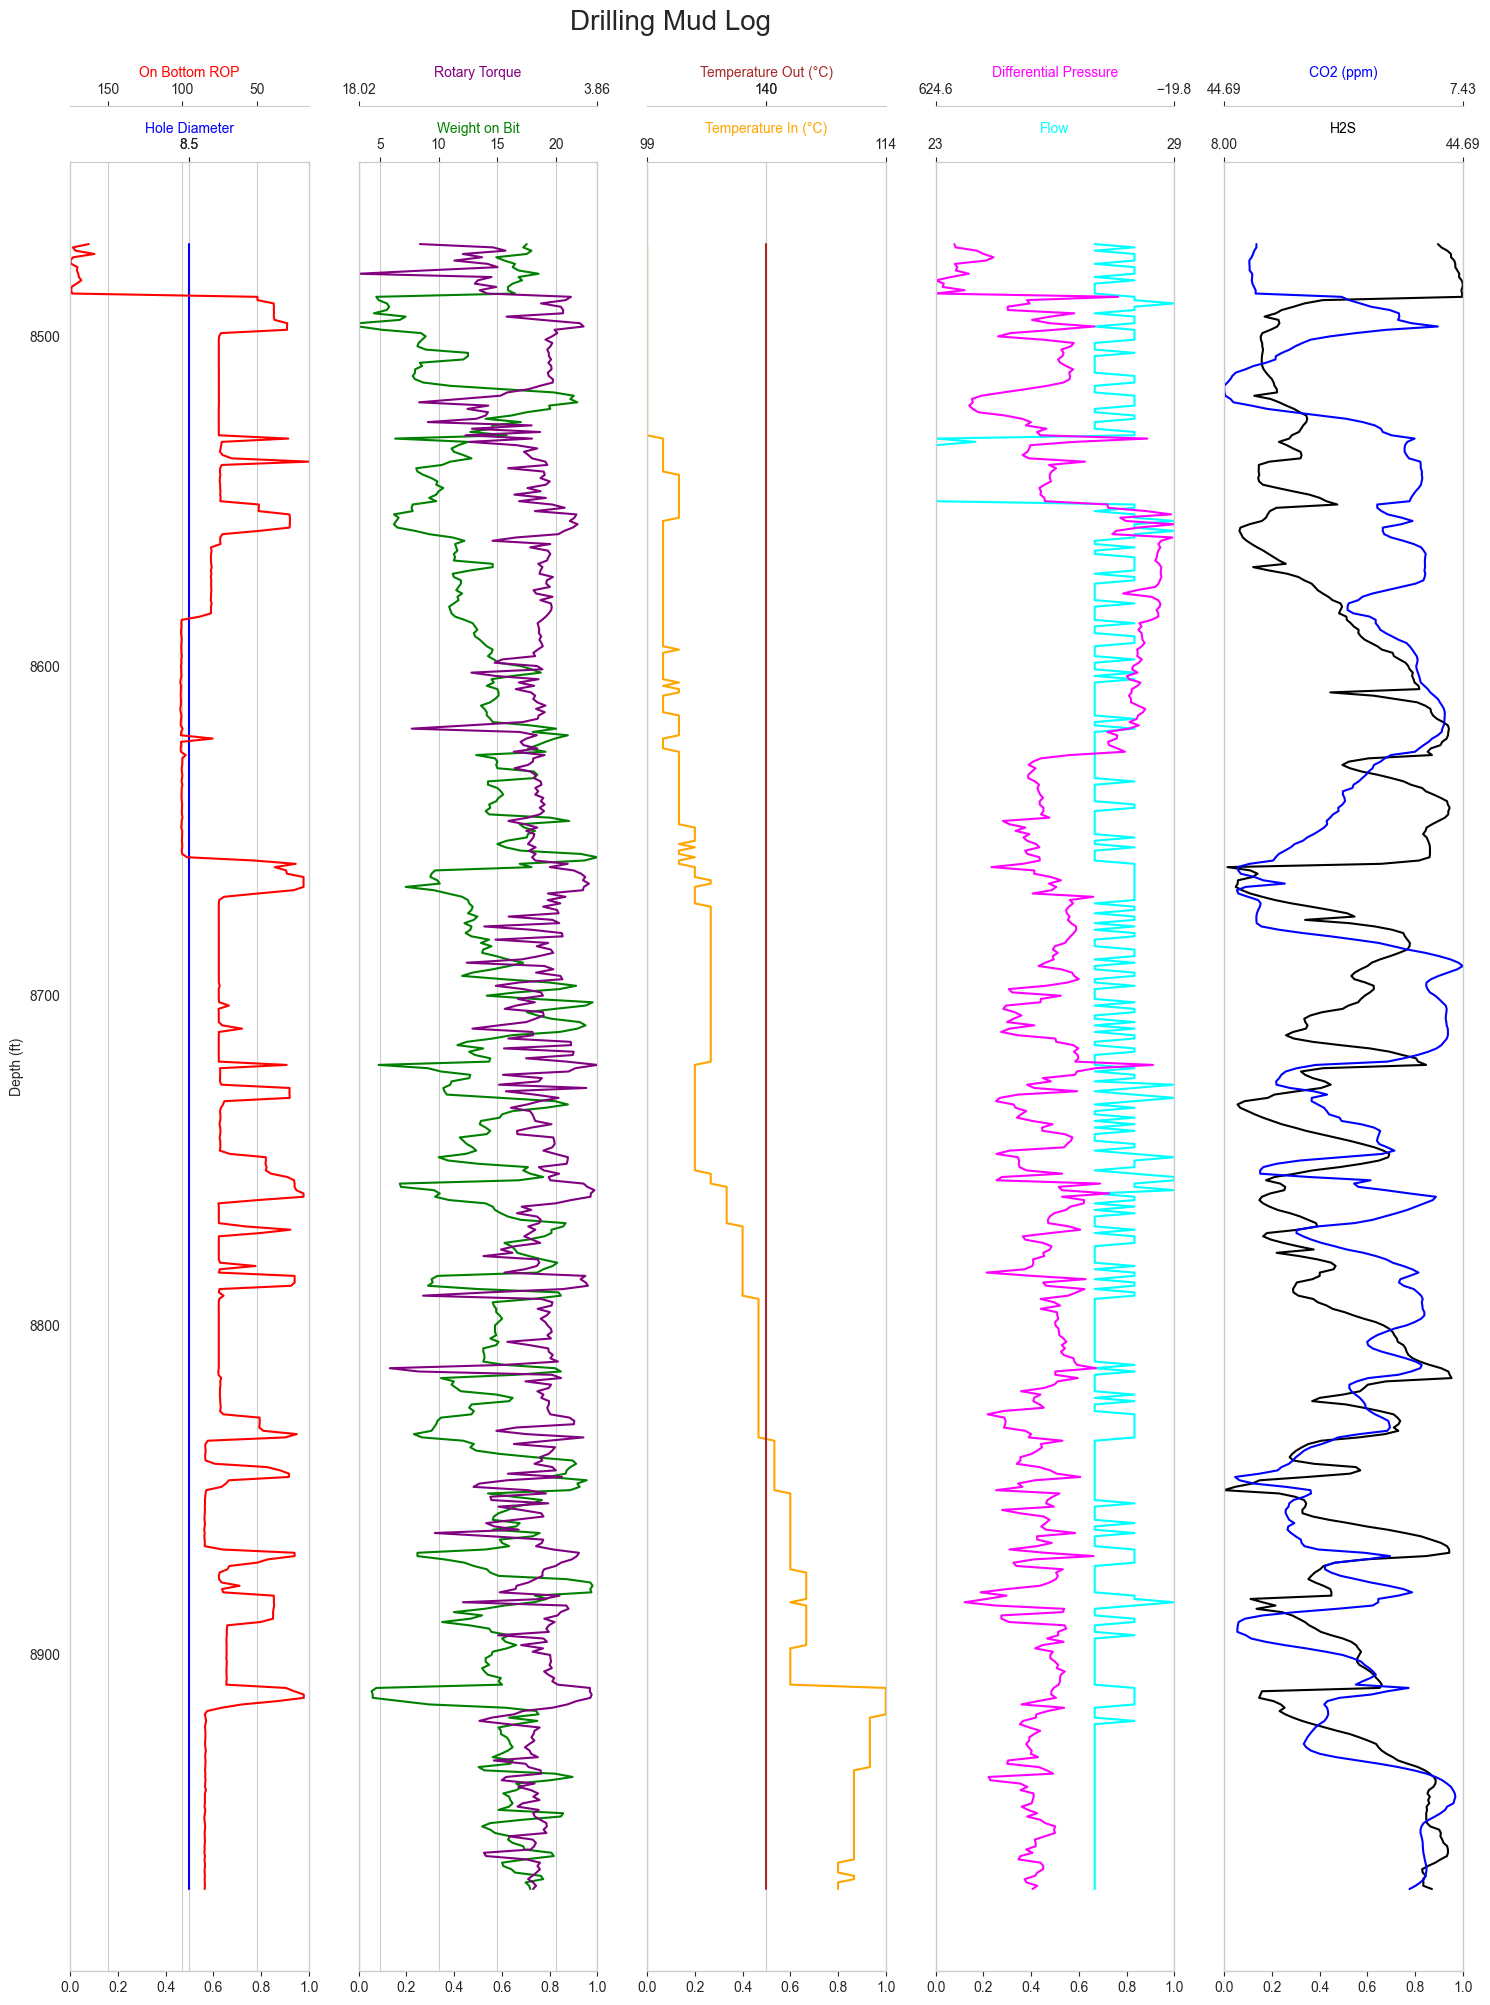

In [17]:
plot_mudlog(dfa[2000:2500])

_**Author: Destiny Otto**_